# model02rp
### Un altro passo: sono arrivate le banche e la banca centrale pure!
#### Sempre in azione l'*Istituto Centrale di Statistica* con a fianco la *Banca d'Italia*

use it in [Notebook viewer](https://nbviewer.org/github/terna/ejmmp/blob/main/model02/model02rp.ipynb) or explore it in [GitHub](https://github.com/terna/ejmmp/tree/main/model02) (with the tools.py and metaActions.py files)

to force the updatem if missing, follow once [Notebook viewer and flush cache](https://nbviewer.org/github/terna/ejmmp/blob/main/model02/model02rp.ipynb?flush_cache=true)

[Wikipedia as a memo](https://en.wikipedia.org/wiki/Stock-flow_consistent_model#cite_note-42)

In [1]:
%%javascript
// to avoid scroll in windows
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import random as r
import matplotlib.pyplot as plt
import commonVar as cmv
import numpy as np
from tools import *
from metaActions import *
from generateSeeds import *
from plot import *
from initSeries import *
import sys

### Stock-flow *model02*, with real and financial elements

- In the model, we observe both the real and monetary sides of the economy.

  

- We consider loans and capital stocks.

  

- Enterprises have initial endowments.

  

- Saving is abstension from consuming, increasing agents' liquidity.

  

- Investments are uniquely for replacement, without technical progress.



### symbol table

[symbol table](https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols) in $\LaTeX$

$a_i$ -  with $a_i \in \mathbf{A}$; agent number $N=|\mathbf{A}|$, `agentList` and`agentNum`

$a^e_i$ -  with $a^e_i \in \mathbf{A^e}$ and $\mathbf{A^e} \subset \mathbf{A}$; employer number $N^e=|\mathbf{A^e}|$ in range $[N^e_{min},N^e_{max}]$, `employerList`

$\mathbf{F}$ - firms' set, with $f_j \in \mathbf{F}$ being $N^f = |\mathbf{F}|$,  with $N^f = |\mathbf{F}| = |\mathbf{A^e}|$ , `firmList`

$\mathbf{A}^w$ - working agents' set, being $\mathbf{A}^w \subseteq \mathbf{A}$, with $N^w_i=|\mathbf{A}^w_i|$ number of working agents employed by employer $i$, also including self-employed employers, with $a_i \in \mathbf{A}^e$

$\mathbf{B}$ - banks' set, with $b_j \in \mathbf{B}$ being $N^b = |\mathbf{B}|$, `bankList`

$x^d$ - interest rate on deposits, `interestRateOnDeposits`

$x^{l^a}$ - interest rate on loans to (private) agents, `interestRateOnLoansVsAgents`

$x^{l^f}$ - interest rate on loans to firms, `interestRateOnLoansVsFirms`

$X^d_{a|f|b}$ - amount of positive interest on deposits for a given interval $t$ for agents $a$ or firms $f$, and negative for banks $b$, `interestOnDeposits`

$X^l_{a|f|b}$ - amount of negative interest on loans for a given interval $t$ for agents $a$ or firms $f$, and positive for banks $b$, `interestOnLoans`

$p$ - price `price`

$u$ - unemployment rate `unemploymentRate`

$dimensional~heterogeneity$ is a $true/false$ chooser, forcing increasing firms to attract more workers. `dimensionalHeterogeneity`

$\pi_{i,t}$ - labor productivity, a uniformly distributed decimal number in range $[\pi_{min},\pi_{max}]$,`productivity`

&Delta;$\pi_{i,t}$ - uniperiodal additive productivity correction in range $[$&Delta;$\pi_{min},$ &Delta;$\pi_{max}]$, `productivityDelta`

$n_{i,t}$ - number of workers in a firm

$q_{i,t}$ - production in quantity, `production`

$\Pi_{i,t}$ - profit, `profit`

$\rho$ - profit distribution share, `rho`

$\delta_{i,t}$ - dividend $\rho\Pi_{i,t}$, `dividend` or `perceivedDividend` 

$W$ - wage `wage`

$R_{i,t}$ - revenues, `revenues`, including both sales revenues, `salesRevenues`, and active interests 

$s_{i,t}$ - sales in quantity, `sales`

$v_{i,t}$ - in**v**entories (final, initial), `initialInventories`, `finalInventories`

$d_{i}$ - deperibility share of the production, `deperibilityShare`, setting $d_{max}$

$c_{i,t}$ - consumption rate, a uniformly distributed decimal number in range $[c_{min},c_{max}]$,`consumptionRate`

$C_{i,t}$ - consumption of $i$ in $t$

$I_{i,t}$  - investment plan  of $i$ in $t$, a uniformly distributed realization in range $[I_{min},I_{max}]$,`investmentProgram`

$\lambda$ -parameter limiting the investment plan, in $I_{i,t} \le \lambda\Pi_{i,t-1}$ , `Lambda`

$H_{i,t}$  - high powered money (cash) held by individuals (also acting as employers), `cashMoney`

$M1_{i,t}$ - checking account money deposits held by  $a_i$ at time $t$, `checkingAccount`

$M1^f_{i,t}$ - firm's bank account (with positive or negative balance), `bankAccount`

$M1^b_{i,t}$ - bank's account (with positive or negative balance) mantained with the central bank , `centralBankAccount`

$\alpha$ - parameter determining the mean of the random normal distribution of the initial endowments of both firms and banks as $\alpha N^w_i$, being $i$ a firm or a bank, `alphaF` or `alphaB`

$\beta$ - parameter determining the standard deviation $\sigma$ of the random normal distribution of the initial endowments of both firms and banks, with $\sigma=\frac{\alpha}{\beta}N^w_i$, being $i$ a firm or a bank, `beta`

the investment and consumption actions are repeated in each cycle, looking around randomly for the sellers; currently `nOfConsumptionActions` $=30$ and `nOfInvestmentActions`$=10$; each consumption buy action is at maximum the 20% of the planned consumptions in that cycle; instead, each investment buy action can reach the whole amount of the investment program of the cycle; each buy action is limited by the residual capabilty of the seller

**magically**, the same good can be a consumption item or an investment one

$T$ - number of cycles `ncycles`

$t$ - current cycle `cycle`


## agent structure

The structure of an **agent**: it can represent an entrepreneur, a worker, an unemployed person.

When an agent is created, the **initialization process** defines:

- its numerical id, `num`
- its entrepreneur status, `entrepreneur`, set to $false$
- the id of its employer, `myEmployer`, set to $0$
- if entrepreneur, the id of its firm, `myFirm`, set to $0$
- $c_{i,0}$ - consumption rate, set to $0$
- $H_{i,0}$ - cash money, set to $0$ 
- $M1_{i,0}$ - checking account money deposits, set to $0$

## firm structure

- $R_{i,0}$ - `revenues`, initial value  $0$
- $s_{i,0}$ - `sales`, initial value  $0$
- $v^i_{i,0}$ - in**v**entories, `initialInventories`, set to $0$ 
- $v^f_{i,0}$ - in**v**entories, `finalInventories`, set to $0$ 
- $d_{i}$ - deperibility share, a uniformly distributed decimal number in range $[0,d_{max}]$,`deperibilityShare`
- $I_{i,0}$  - investment plan, set to $0$
- $\Pi_{i,0}$ - profit, set to $0$, being the related dividend $D_{i,0}$, set to $0$
- $M1^f_{i,0}$ - firm's bank account, set to $0$
- $\pi_{i,t-1}$ set within the initialization step

## bank structure

- $R_{i,0}$ - `revenues`, initial value  $0$
- $I_{i,0}$  - investment plan, set to $0$
- $\Pi_{i,0}$ - profit, set to $0$, being the related dividend $D_{i,0}$, set to $0$
- $M1^b_{i,0}$ - bank's account mantained with the central bank, set to $0$
- $\pi_{i,t-1}$ set within the initialization step



each **agent** has the **functions**:

- **buyConsumptionGoods** 

  $C_{i,t}=c_{i,t} (W+D_{i,t-1}+X^d_{i,t-1}-X^l_{i,t-1})$; using $D_{i,t-1},X^d_{i,t-1},X^l_{i,t-1}$ we introduce lags with (possible) cyclical effect

  being $bu$ the buyer and $se$ the seller (firm), for each fraction $C_{i,t}/k$ 

  ($k$ is the number of buying actions in each cycle with random share [0,`maxConsumptionShareInSubstep`))

  &Delta;$M1^f_{se,t}=C_{bu,t}/k$

  &Delta;$M1_{bu,t}=-C_{bu,t}/k$




each **firm** has the **functions**:

- **produce** function (production in quantity), with:

  $\pi_{i,t}=\pi_{i,t-1}+$&Delta;$\pi_{i,t}$

  $q_{i,t}=n_{i,t} \pi_{i,t}$

  

- **payWages**

  paying $W$ to each worker in each time $t$

  &Delta;$M1_{i,t}=W$ for  $a_i \in \mathbf{A}^w$ 

  &Delta;$M1^f_{i,t}=-W \mathbf{N}^w_i$ for $a_i \in \mathbf{A}^e$ 

  

- **buyInvestmentGoods**

  $I_{j,t}$ for $f_j \in \mathbf{F}$  ($I_{j,t}$ is exogenously set), , with $I_{i,t} \le \lambda\Pi_{i,t-1}$, being $\lambda\Pi_{i,t-1}$ a proxy of investment sustainability, introducing a lag with (possible) cyclical effect

  being $bu$ the buyer (firm) and $se$ the seller (firm), for each fraction $I_{j,t}/k$

  ($k$ is the number of investment actions in each cycle, with random share [0,`maxInvestmentShareInSubstep`))

  &Delta;$M1^f_{se,t}=I_{bu,t}/k$

  &Delta;$M1^f_{bu,t}=-I_{bu,t}/k$

  

- **makeBalanceSheet**

  $v^f_{i,t}=v^i_{i,t}+(q_{i,t}-s_{i,t}) (1 - d_{i})$

  $R_{i,t}=p s_{i,t}+X^d_{i,t}$

  $\Pi_{i,t}=R_{i,t}-W n_{i,t}-X^l_{i,t}+p(v^f_{i,t}-v^i_{i,t})$

  reordering, we have:

  $\underbrace{\Pi_{i,t}+W n_{i,t}+X^l_{i,t}}_{\textrm{direct added value}}=\underbrace{R_{i,t}+p(v^f_{i,t}-v^i_{i,t})}_{\textrm{indirect added value (*)}}$

  (*) the cost of bought-in materials and components is missing by construction in this version of the model

- **distributeDividend**

  $\delta_{i,t}=\rho\Pi_{i,t}$​

  &Delta;$M1_{i,t}=\delta_{i,t}$

  &Delta;$M1^f_{i,t}=-\delta_{i,t}$

  

each **bank** has the **functions**:

- **produce** function (production of bank services in quantity), analogously with the firm one

  

- **payWages**

  paying $W$ to each worker in each time $t$

  &Delta;$M1_{i,t}=W$ for  $a_i \in \mathbf{A}^w$ 

  &Delta;$M1^f_{i,t}=-W \mathbf{N}^w_i$ for $a_i \in \mathbf{A}^e$

  

- **buyInvestmentGoods**

  $I_{j,t}$ for $f_j \in \mathbf{F}$  ($I_{j,t}$ is exogenously set), , with $I_{i,t} \le \lambda\Pi_{i,t-1}$, being $\lambda\Pi_{i,t-1}$ a proxy of investment sustainability, introducing a lag with (possible) cyclical effect

  being $bu$ the buyer (firm) and $se$ the seller (firm), for each fraction $I_{j,t}/k$

  ($k$ is the number of investment actions in each cycle, with random share [0,`maxInvestmentShareInSubstep`))

  &Delta;$M1^f_{se,t}=I_{bu,t}/k$

  &Delta;$M1^b_{bu,t}=-I_{bu,t}/k$

  

- **distributeDividend**

  $\delta_{i,t}=\rho\Pi_{i,t}$​​

  &Delta;$M1_{i,t}=\delta_{i,t}$

  &Delta;$M1^b_{i,t}=-\delta_{i,t}$

  

- **makeBalanceSheet**, with:

  being $d_{i}=1$ we have $v^f_{i,t}=v^i_{i,t}=0$

  $R_{i,t}=p s_{i,t}+\sum_{a_i}X^l_{i,t}+\sum_{f_i}X^l_{i,t}$

  $\Pi_{i,t}=R_{i,t}-W n_{i,t}-\sum_{a_i}X^d_{i,t}-\sum_{f_i}X^d_{i,t}$

  reordering, we have:

  $\underbrace{\Pi_{i,t}+W n_{i,t}+\sum_{a_i}X^d_{i,t}}_{\textrm{direct added value}}=\underbrace{R_{i,t}-\sum_{f_i}X^d_{i,t}}_{\textrm{indirect added value (*)}}$

  (*) the cost of bought-in materials and components is missing by construction in this version of the model, excepted the interests on deposits paid to firms				



In [3]:
class Agent():
    def __init__(self, num,r,seed):
        self.num=num
        self.entrepreneur=False
        #self.myFirm=0
        self.myEnterprise=0
        self.myEmployer=0
        self.consumptionRate=0
        self.cashMoney=0
        self.checkingAccount=0
        self.perceivedWage=0
        self.perceivedDividend=0
        self.myBank=0
        self.interestOnDeposits=0
        self.interestOnLoans=0
        self.r=r.Random()
        self.r.seed(seed)
        self.myFirmBankList=[]

    def buyConsumptionGoods(self,k):
        if k==0: 
            self.consumptionRate=self.r.uniform(cmv.consumptionRateMin,cmv.consumptionRateMax)
            self.consumption=(self.perceivedWage+self.perceivedDividend+\
                self.interestOnDeposits-self.interestOnLoans)*self.consumptionRate
            if self.consumption < 0: self.consumption=0 

            self.interestOnDeposits=0
            self.interestOnLoans=0
            self.perceivedWage=0
            self.perceivedDividend=0
            self.madeConsumption=0
        
        if self.myFirmBankList==[]: self.myFirmBankList=cmv.firmList+cmv.bankList
        self.r.shuffle(self.myFirmBankList)
        mySeller=self.myFirmBankList[0]
        self.purchase=self.r.uniform(0,cmv.maxConsumptionShareInSubstep)*self.consumption 
                            # mean value should be calibrated with thenumber of buy action
        self.purchase=min(self.purchase,self.consumption-self.madeConsumption)
        self.purchase=min(self.purchase,cmv.price*(mySeller.production+\
                                        mySeller.initialInventories-mySeller.sales))
        mySeller.sales+=self.purchase/cmv.price
        if mySeller.__class__.__name__=="Firm": mySeller.bankAccount+=self.purchase
        if mySeller.__class__.__name__=="Bank": mySeller.centralBankAccount+=self.purchase
        self.checkingAccount-=self.purchase
        self.madeConsumption+=self.purchase
    


In [4]:
class Firm():
    def __init__(self, num, r,seed):
        self.num=num
        self.myWorkers=[]
        self.myEntrepreneur=0
        self.productivity=0
        self.initialInventories=0
        self.finalInventories=0
        self.bankAccount=0
        self.salesRevenues=0 #sales*price
        self.revenues=0
        self.sales=0
        self.deperibilityShare=r.uniform(0,cmv.maxDeperibilityShare)
        self.investmentProgram=0
        self.profit=0
        self.madeInvestment=0
        self.interestOnDeposits=0
        self.interestOnLoans=0
        self.addedValue=0
        self.myBank=0
        self.r=r.Random()
        self.r.seed(seed)
        
    def produce(self):
        # clean interests values while starting this cycle
        self.interestOnLoans=0
        self.interestOnDeposits=0
        
        self.initialInventories=self.finalInventories
        self.productivity+=self.r.uniform(cmv.productivityDeltaMin,cmv.productivityDeltaMax)
        self.productivity=max(self.productivity,0)
        
        self.production=len(self.myWorkers)*self.productivity
        self.sales=0

    def payWages(self):
        for anAgent in self.myWorkers:
            anAgent.perceivedWage=cmv.wage
            anAgent.checkingAccount+=cmv.wage
            anAgent.myBank.centralBankAccount+=cmv.wage
        self.bankAccount-=cmv.wage*len(self.myWorkers)
        self.myBank.centralBankAccount-=cmv.wage*len(self.myWorkers)
            
    def buyInvestmentGoods(self,k):
        if k==0: 
            profitControl=max(0,self.profit)
            self.investmentProgram=\
                 min(r.uniform(cmv.investmentMin,cmv.investmentMax),cmv.Lambda*profitControl)
            self.madeInvestment=0
                       
        self.r.shuffle(cmv.firmList)
        mySeller=cmv.firmList[0]
        self.myInvestment=self.r.uniform(0,cmv.maxInvestmentShareInSubstep)*self.investmentProgram
        self.myInvestment=min(self.myInvestment,cmv.price*(mySeller.production+\
                              mySeller.initialInventories-mySeller.sales))
        mySeller.sales+=self.myInvestment/cmv.price
        mySeller.bankAccount+=self.myInvestment
        
        self.bankAccount-=self.myInvestment
        self.investmentProgram-=self.myInvestment
        self.madeInvestment+=self.myInvestment
        
    def makeBalanceSheet(self):
        self.lostProduction=0
        if self.production - self.sales > 0: 
            self.lostProduction=(self.production - self.sales)*self.deperibilityShare
        #print(self.num, lostProduction,self.productivity)
        self.finalInventories=self.initialInventories+self.production-\
                              self.sales-self.lostProduction
        self.salesRevenues=self.sales*cmv.price
        self.revenues=self.salesRevenues+self.interestOnDeposits
        self.profit=self.revenues - len(self.myWorkers)*cmv.wage\
          - self.interestOnLoans + \
          (self.finalInventories-self.initialInventories)*cmv.price
        self.addedValue=self.profit+self.interestOnLoans+len(self.myWorkers)*cmv.wage
        
        """
        if self.num==33:
            print("%3d %.5f %.5f %.5f %.5f %.5f %.5f %.5f " % \
              (self.num,self.bankAccount,self.interestOnLoans,self.profit,self.revenues,\
               self.interestOnDeposits,self.salesRevenues,self.madeInvestment))
        """
        
    def distributeDividend(self):
        if self.profit > 0:
            dividend=cmv.rho*self.profit
            self.bankAccount-=dividend
            self.myEntrepreneur.checkingAccount+=dividend
            self.myEntrepreneur.perceivedDividend=dividend        


In [5]:
class Bank(Firm):
    def __init__(self, num, r,seed):
        super().__init__(num,r,seed)
        self.myPrivateClients=[]
        self.myCommercialClients=[]
        self.myDebtsVsAgents=0
        self.myDebtsVsFirms=0
        self.myCreditsVsAgents=0
        self.myCreditsVsFirms=0
        self.centralBankAccount=0
        
        del self.bankAccount
        del self.myBank
        
        self.myPrivateClientsTotalInterestOnDeposits=0
        self.myPrivateClientsTotalInterestOnLoans=0
        self.myCommercialClientsTotalInterestOnDeposits=0
        self.myCommercialClientsTotalInterestOnLoans=0

        self.r=r.Random()
        self.r.seed(seed)

        
    def payWages(self):
        for anAgent in self.myWorkers:
            anAgent.perceivedWage=cmv.wage
            anAgent.checkingAccount+=cmv.wage
            anAgent.myBank.centralBankAccount+=cmv.wage
        self.centralBankAccount-=cmv.wage*len(self.myWorkers)
        self.centralBankAccount-=cmv.wage*len(self.myWorkers)

        
    def buyInvestmentGoods(self,k):
        if k==0: 
            profitControl=max(0,self.profit)
            self.investmentProgram=\
                 min(r.uniform(cmv.investmentMin,cmv.investmentMax),cmv.Lambda*profitControl)
            self.madeInvestment=0
                       
        self.r.shuffle(cmv.firmList)
        mySeller=cmv.firmList[0]
        self.myInvestment=self.r.uniform(0,cmv.maxInvestmentShareInSubstep)*self.investmentProgram
        self.myInvestment=min(self.myInvestment,cmv.price*(mySeller.production+\
                              mySeller.initialInventories-mySeller.sales))
        mySeller.sales+=self.myInvestment/cmv.price
        mySeller.bankAccount+=self.myInvestment
        
        self.centralBankAccount-=self.myInvestment
        self.investmentProgram-=self.myInvestment
        self.madeInvestment+=self.myInvestment

        
    def makeBalanceSheet(self):
        self.lostProduction=0
        #if self.production - self.sales > 0: 
        #    self.lostProduction=self.production - self.sales
        self.finalInventories=0
        self.salesRevenues=self.sales*cmv.price
        self.revenues=self.salesRevenues + self.myPrivateClientsTotalInterestOnLoans\
                                         + self.myCommercialClientsTotalInterestOnLoans

        self.profit=self.revenues - len(self.myWorkers)*cmv.wage\
           - self.myPrivateClientsTotalInterestOnDeposits - self.myCommercialClientsTotalInterestOnDeposits

        self.addedValue=self.profit+len(self.myWorkers)*cmv.wage\
          - self.myPrivateClientsTotalInterestOnLoans - self.myCommercialClientsTotalInterestOnLoans \
          + self.myPrivateClientsTotalInterestOnDeposits 
        

    def distributeDividend(self):
        if self.profit > 0:
            dividend=cmv.rho*self.profit
            self.centralBankAccount-=dividend
            self.myEntrepreneur.checkingAccount+=dividend
            self.myEntrepreneur.perceivedDividend=dividend        

            
    def computeAndApplyInterests(self):

        #interest are always calculate as positive values, than we add or subctract them 
        #to and from the accounts and we add them to revenues or costs
        
        for aPrivateClient in self.myPrivateClients:
            if aPrivateClient.checkingAccount >=0:
                interests=aPrivateClient.checkingAccount*cmv.interestRateOnDeposits
                aPrivateClient.checkingAccount+=interests
                aPrivateClient.interestOnDeposits=interests
                
            else: #aPrivateClient.checkingAccount < 0
                interests=abs(aPrivateClient.checkingAccount*cmv.interestRateOnLoansVsAgents)
                aPrivateClient.checkingAccount-=interests
                aPrivateClient.interestOnLoans=interests
               
        for aCommercialClient in self.myCommercialClients:
            if aCommercialClient.bankAccount >=0:
                interests=aCommercialClient.bankAccount*cmv.interestRateOnDeposits
                aCommercialClient.bankAccount+=interests
                aCommercialClient.interestOnDeposits=interests

            else: #aCommercialClient.bankAccount < 0
                interests=abs(aCommercialClient.bankAccount*cmv.interestRateOnLoansVsFirms)
                aCommercialClient.bankAccount-=interests
                aCommercialClient.interestOnLoans=interests
                
        self.myPrivateClientsTotalInterestOnDeposits=\
                 sum(list(self.myPrivateClients[i].interestOnDeposits for i \
                 in range(len(self.myPrivateClients))))
        
        self.myPrivateClientsTotalInterestOnLoans=\
                 sum(list(self.myPrivateClients[i].interestOnLoans    for i \
                 in range(len(self.myPrivateClients))))
        
        self.myCommercialClientsTotalInterestOnDeposits=\
                 sum(list(self.myCommercialClients[i].interestOnDeposits for i \
                 in range(len(self.myCommercialClients))))
        
        self.myCommercialClientsTotalInterestOnLoans=\
                 sum(list(self.myCommercialClients[i].interestOnLoans    for i \
                 in range(len(self.myCommercialClients))))
        
    def makeFinancialAccounts(self):
        self.myDebtsVsAgents=0
        self.myDebtsVsFirms=0
        self.myCreditsVsAgents=0
        self.myCreditsVsFirms=0

        for aPrivateClient in  self.myPrivateClients:
            if aPrivateClient.checkingAccount>=0: \
                self.myDebtsVsAgents+=aPrivateClient.checkingAccount
            if aPrivateClient.checkingAccount<0: \
                self.myCreditsVsAgents+=aPrivateClient.checkingAccount
        for aCommercialClient in  self.myCommercialClients:
            if aCommercialClient.bankAccount>=0: \
                self.myDebtsVsFirms+=aCommercialClient.bankAccount
            if aCommercialClient.bankAccount<0: \
                self.myCreditsVsFirms+=aCommercialClient.bankAccount
        
        

### agent setup

- agent basic creation

  

- creation of entrepreneur list

  

- selecting entrepreneurs and creating their firms or their banks

  

- with a given (heterogeneous) productivity

  

- linking the firm or the bank to its entrepreneur, considering the entrepreneur itself as a worker in its firm or bank

  

- creation of a temporary workforce list of to-be-employed agent, escluding entrepreneurs (already self employed)

  

- applying the unmployement rate to exclude agents

  

- assigning workforce (to-be-employed agents) to firms or banks, with a reinforcement mechanism, gradually giving more attraction/hiring capability to firms or banks growing the most

  

- assigning agents and firms to banks in a random way

  

- endowments provided to the enterprises are proportional to the initial workforce, being extracted from a random-normal distribution with $\mu=\alpha N^w_i$ and $\sigma=\frac{\alpha}{\beta}N^w_i$ (substituting $\alpha$ with $\alpha^f$ for the firms, or with $\alpha^b$ for the banks)

In [6]:
def setup(r,seed):
    
    seedManager(r,seed,'setup',setup)
    
    #print(r.random(),setup.r.random())
        
    cmv.agentList=[]
    for n in range(cmv.agentNum):
        anAgent=Agent(n+1,r,cmv.agentSeedList[n])
        cmv.agentList.append(anAgent)
        
    # creation of: entrepreneur list; firm list; bank list
    cmv.entrepreneurNum=setup.r.randint(cmv.entrepreneurMin, cmv.entrepreneurMax)
    cmv.bankNum=setup.r.randint(cmv.bankMin, cmv.bankMax)
    
    cmv.entrepreneurList=[]
    cmv.firmList=[]
    cmv.bankList=[]
    entrepreneurCandidates=cmv.agentList.copy()

    for n in range(cmv.entrepreneurNum):
        
        i=setup.r.randint(0,len(entrepreneurCandidates)-1)
        
        entrepreneurCandidates[i].entrepreneur=True

        if len(cmv.bankList) < cmv.bankNum:
            newEnterprise=Bank(entrepreneurCandidates[i].num,\
                               r,cmv.bankSeedList[len(cmv.bankList)])
        else:
            newEnterprise=Firm(entrepreneurCandidates[i].num,\
                               r,cmv.firmSeedList[len(cmv.firmList)])

        entrepreneurCandidates[i].myEnterprise=newEnterprise
        entrepreneurCandidates[i].myEmployer=newEnterprise
        newEnterprise.myEntrepreneur=entrepreneurCandidates[i]
        newEnterprise.myWorkers.append(entrepreneurCandidates[i])
        newEnterprise.productivity=\
                setup.r.uniform(cmv.productivityMin,cmv.productivityMax)
        cmv.entrepreneurList.append(entrepreneurCandidates.pop(i))
        if newEnterprise.__class__.__name__=="Bank": cmv.bankList.append(newEnterprise)
        if newEnterprise.__class__.__name__=="Firm": cmv.firmList.append(newEnterprise)

    cmv.firmNum=len(cmv.firmList)
    
    # creation of workforce list
    toBeEmployed=[]

    for anAgent in cmv.agentList:
        if not anAgent.entrepreneur: toBeEmployed.append(anAgent)
    for k in range(round(cmv.unemploymentRate*cmv.agentNum)):
        toBeEmployed.pop(setup.r.randint(0,len(toBeEmployed)))
    #len(toBeEmployed)

    # assigning workforce to firms and banks
    tmpEnterpriseListWithDuplications=cmv.firmList+cmv.bankList
    for anAgent in toBeEmployed:
        choice=setup.r.choice(tmpEnterpriseListWithDuplications)
        anAgent.myEmployer=choice
        choice.myWorkers.append(anAgent)
        if cmv.dimensionalHeterogeneity: tmpEnterpriseListWithDuplications.append(choice)
            
            
    # assigning agents to firms and banks
    
    if len(cmv.bankList)>0:
        for anAgent in cmv.agentList:
            anAgent.myBank=setup.r.choice(cmv.bankList)
            anAgent.myBank.myPrivateClients.append(anAgent)
            
        for aFirm in cmv.firmList:
            aFirm.myBank=setup.r.choice(cmv.bankList)
            aFirm.myBank.myCommercialClients.append(aFirm)

    # assigning endowments to firms and banks

    for aFirm in cmv.firmList:
        aFirm.bankAccount=setup.r.gauss(cmv.alphaF*len(aFirm.myWorkers),\
                                       (cmv.alphaF/cmv.beta)*len(aFirm.myWorkers))

    for aBank in cmv.bankList:
        aBank.centralBankAccount=setup.r.gauss(cmv.alphaB*len(aBank.myWorkers),\
                                              (cmv.alphaB/cmv.beta)*len(aBank.myWorkers))

    initSeries()

### meta actions (in `metaActions.py`)





- *produceAll* orders to the firms to produce and to collects the results

  

- *payWagesAll* orders to the firms to pay wages, also to the entrepreneurs

  

- *buyConsumptionGoodsAll* orders to the agents to buy consumption goods

  

- *buyInvestmentGoodsAll* orders to the firms to buy investment goods

  

- *buyConsumptionOrInvestmentGoodsAll* orders to the agents and to the firms to buy consumption or investment goods

  

- *makeBalanceSheetAll* with firm making accounts

  

- *distributeDividendAll* attributing the $\rho$ share of firm profits to the entrepreneurs 

  

- *accountCashMoneyAll* summarizing eveyone cash money at the end of a cycle

  

- *accountCheckingAccountAll* summarizing eveyone checking accounts at the end of a cycle

  

- *accountBankingAccountAll* summarizing firm banking accounts at the end of a cycle

  

- *computeAndApplyInterestsAll* calculating the interests on deposits and loans for each agent and firm (and symmetrically for banks) and updatating accounts

  

- *makeBankFinancialAccountsAll* summmarinzing all the checking and bank accounts


### model parameters



In [7]:
cmv.agentNum=100
cmv.entrepreneurMin=6
cmv.entrepreneurMax=20
cmv.bankMin=2
cmv.bankMax=3 

if cmv.bankMax > cmv.entrepreneurMin:
    print ("Bank maximum number cannot exceed the minimum number of firms!")
    sys.exit(0)

cmv.price=1

cmv.unemploymentRate=0
cmv.dimensionalHeterogeneity=True

cmv.productivityMin=0.8
cmv.productivityMax=1.2
cmv.productivityDeltaMin=cmv.productivityMin-1
cmv.productivityDeltaMax=cmv.productivityMax-1

cmv.maxDeperibilityShare=0 #0.5

cmv.wage=1
cmv.rho=0.5 #1
cmv.consumptionRateMin=0 #0.5
cmv.consumptionRateMax=0 #1

cmv.investmentMin=0 #1
cmv.investmentMax=0 #15
cmv.Lambda=3

cmv.nOfConsumptionActions=30
cmv.maxConsumptionShareInSubstep=0.3
cmv.nOfInvestmentActions=10
cmv.maxInvestmentShareInSubstep=0.3

cmv.interestRateOnDeposits=0 #0.01
cmv.interestRateOnLoansVsAgents=0 #0.03
cmv.interestRateOnLoansVsFirms=0 #0.10

cmv.alphaF=20
cmv.alphaB=10
cmv.beta=5

cmv.ncycles=1
cmv.cycle=0

## <p style="color:red">model machine</p>

- a random seed determining the random number sequences



- a list of actions (meta ones)



- an engine excecuting the meta actions (their code in `metaAcions,py` file, in the same folder of the notebook; online, look a the model [GitHub](https://github.com/terna/ejmmp/tree/main/model02)

  

- random seed sequence, to have independent each class instance or function using random number, based on `generateSeed()` in  `generateSeeds.py` file, in the same folder of the notebook; online, look a the model [GitHub](https://github.com/terna/ejmmp/tree/main/model02)



- display tools; their code is hidden into the file `tools.py`, in the same folder of the notebook; online, look a the model [GitHub](https://github.com/terna/ejmmp/tree/main/model02)



-------------------------------------------
enterprise number 9
-------------------------------------------

-------------------------------------------
"national" accounts
-------------------------------------------

  t	total	initial		consum.	invest.	final
	a.v.	invent.				invent.
  1	76.978	0.000	    |	0.000	0.000	76.978






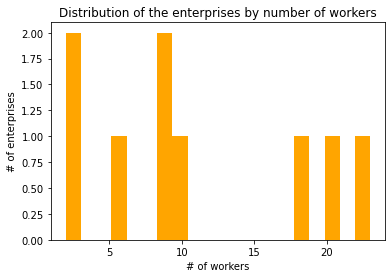

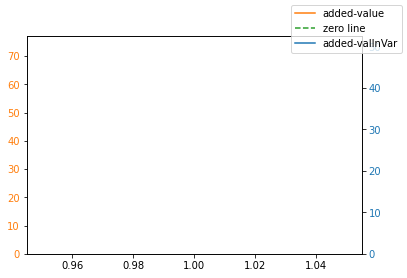

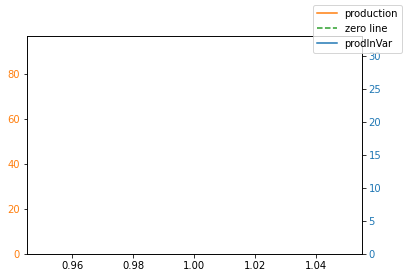

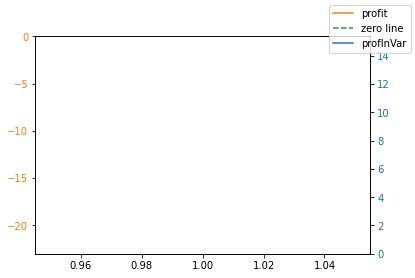

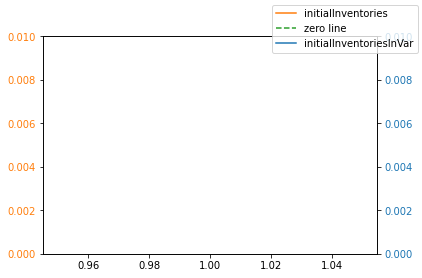

/Users/pt/GitHub/ejmmp/model02/plot.py:11: UserWarning: Attempting to set identical bottom == top == 76.97761830316819 results in singular transformations; automatically expanding.
  ax1.set_ylim(y1lim)


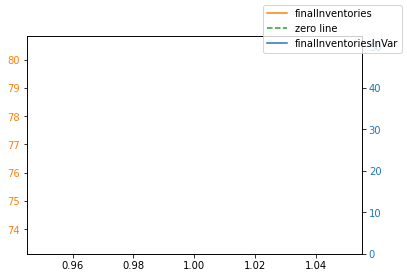

/Users/pt/GitHub/ejmmp/model02/plot.py:11: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax1.set_ylim(y1lim)
/Users/pt/GitHub/ejmmp/model02/plot.py:19: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(y2lim)


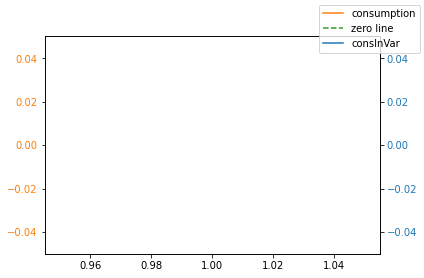

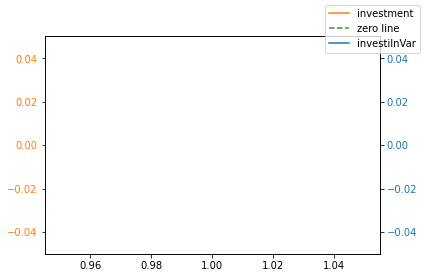

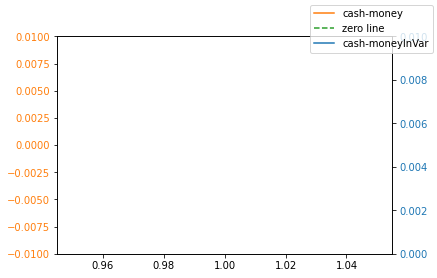

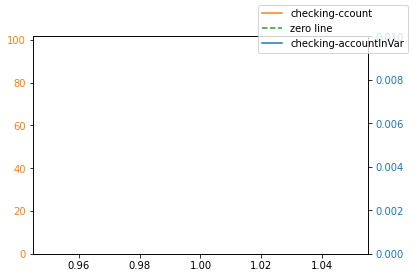

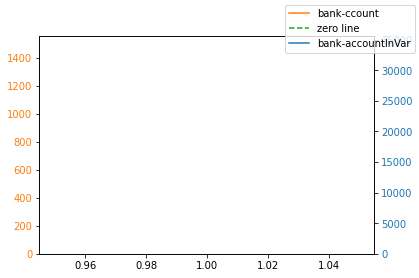

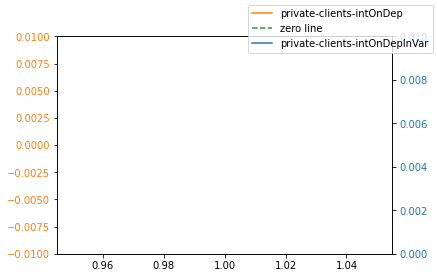

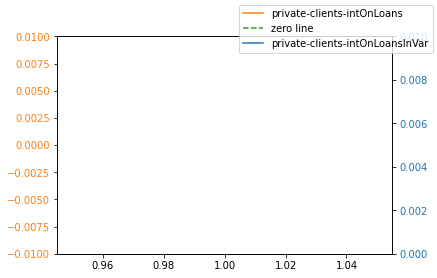

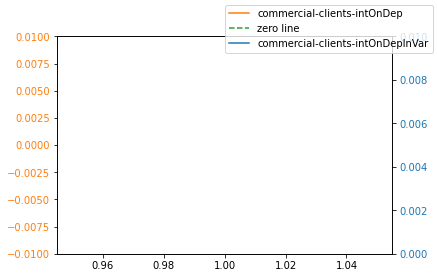

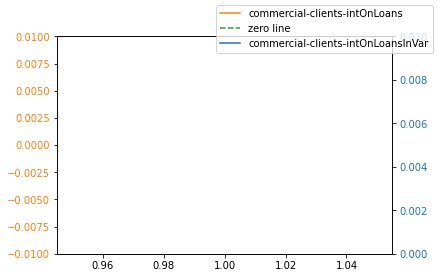

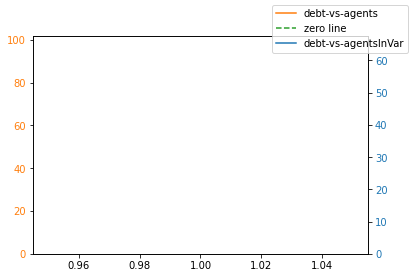

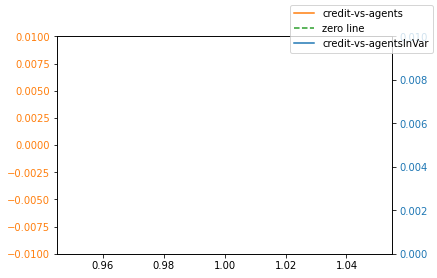

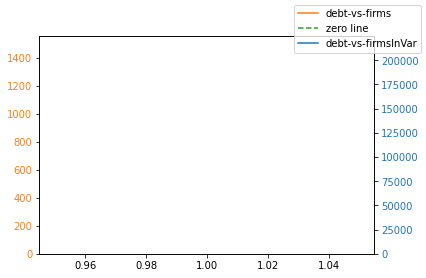

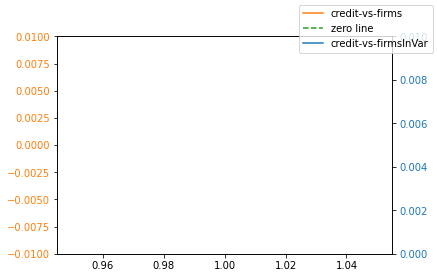

In [8]:
# the seed must be in range -2147483648 to 2147483647
r.seed(12345)

generateSeeds()

setup(r,cmv.functionSeedList[0])

cmv.actionList=["produceAll()","payWagesAll()",\
                "buyConsumptionOrInvestmentGoodsAll(r,cmv.functionSeedList[3])",\
                "computeAndApplyInterestsAll()","makeBalanceSheetAll()",\
                "distributeDividendAll()","accountCashMoneyAll()",\
                "accountCheckingAccountAll()","accountBankAccountAll()",\
                "makeBankFinancialAccountsAll()"\
                ]

for cmv.cycle in range(cmv.ncycles):
    for anAction in cmv.actionList:
            exec(anAction)

makeHist() 

nationalAccounts()

makePlots()


In [9]:
cmv.totalCheckingAccountSeries

[101.55549236158421]

In [10]:
cmv.totalBankAccountSeries

[1554.494934015823]

In [11]:
for anItem in cmv.bankList:
    print(len(anItem.myWorkers))

9
9


In [12]:
for anItem in cmv.firmList:
    print(len(anItem.myWorkers))

23
3
20
10
2
18
6


In [13]:
for aBank in cmv.bankList:
    print(aBank.num,len(aBank.myWorkers),aBank.centralBankAccount)


37 9 71.94202891147445
11 9 120.74620501544635


In [14]:
for aFirm in cmv.firmList:
    print(aFirm.num,len(aFirm.myWorkers),aFirm.bankAccount)


55 23 446.71563897495486
76 3 52.34082978955505
85 20 550.3711372276837
31 10 108.65445846903098
33 2 30.548004014681144
35 18 250.8322844987552
97 6 115.0325810411622


In [15]:
for aBank in cmv.bankList:
    print(aBank.num,aBank.profit)


37 -9.0
11 -9.0


In [16]:
for aFirm in cmv.firmList:
    print(aFirm.num,len(aFirm.myWorkers),aFirm.profit)


55 23 -4.489573428572026
76 3 0.5207965972089248
85 20 -3.407581490435007
31 10 1.462642237797791
33 2 0.2444304834453468
35 18 -0.23621150099321397
97 6 0.8831154047163707


In [17]:
cmv.bankList[1].centralBankAccount

120.74620501544635

In [18]:
-117.05797108852555 + 147.74620501544635

30.6882339269208

In [19]:
cmv.firmList[0].profit

-4.489573428572026

In [20]:
cmv.firmList[0].production

18.510426571427974

In [21]:
len(cmv.firmList[0].myWorkers)

23

In [22]:
cmv.firmList[0].productivity

0.8048011552794772

In [23]:
cmv.firmList[0].finalInventories

18.510426571427974

In [24]:
cmv.firmList[0].lostProduction

0.0

In [25]:
cmv.firmList[0].sales

0.0

In [26]:
cmv.firmList[0].salesRevenues

0.0

In [27]:
cmv.firmList[0].deperibilityShare

0.0

In [28]:
cmv.totalProfitSeries[0]

-23.022381696831815

In [29]:
cmv.totalProductionSeries[0]

96.65631801253964

In [36]:
tot=0
for i in range(cmv.firmNum):
    if cmv.firmList[i].profit < 0:
        tot+=cmv.firmList[i].profit
tot

-8.133366420000247

In [32]:
list(cmv.bankList[i].profit for i in range(cmv.bankNum))

[-9.0, -9.0]